In [1]:
from pandas import Series, DataFrame
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from datetime import datetime
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from datetime import *
from random import *

pd.set_option('display.max_columns', None)

gbr = pd.read_csv('gbr_predictions_12_15.csv')
bagr = pd.read_csv('bagr_predictions_12_15.csv')

past_2017 = pd.read_csv('past_2017.csv').dropna() #dropna to get rid of AFC vs NFC game
past_2018 = pd.read_csv('past_2018.csv').dropna() #dropna to get rid of AFC vs NFC game
past_2019 = pd.read_csv('past_2019_12_15.csv')
future_2019 = pd.read_csv('future_12_15.csv')

all_games = pd.read_csv('allgames_12_15.csv')

all_games['Week'] = all_games['Week'].replace(['WC', 'DP', 'CC', 'SB'], [18, 19, 20, 21])
all_games['Week'] = all_games['Week'].astype(int)


In [2]:
current_week = all_games[all_games['Season']==2019]['Week'].max() # get rid of -1 when predicting future

future_2019['Week'] = current_week
future_2019['Season'] = 2019

# Derive Week and season of lines to create composite key with all_games

def getWeek2019(s):
        new_date = date(int(s[:4]), int(s[5:7]), int(s[8:10]))
        for i in range(1,current_week+1):
            if (new_date < date(2019,9,3) + timedelta(7*i)):
                return i
            
past_2019['Week'] = past_2019['Date'].apply(getWeek2019)
past_2019['Season'] = 2019

def getWeek2018(s):
        new_date = date(int(s[:4]), int(s[5:7]), int(s[8:10]))
        for i in range(1,22):
            if (new_date < date(2018,9,4) + timedelta(7*i)):
                return i
        return 21
            
past_2018['Week'] = past_2018['Date'].apply(getWeek2018)
past_2018['Season'] = 2018

def getWeek2017(s):
        new_date = date(int(s[:4]), int(s[5:7]), int(s[8:10]))
        for i in range(1,22):
            if (new_date < date(2017,9,5) + timedelta(7*i)):
                return i
        return 21
            
past_2017['Week'] = past_2017['Date'].apply(getWeek2017)
past_2017['Season'] = 2017

past_2019 = past_2019[past_2019['Week'] < current_week]

lines = past_2017.append(past_2018).append(past_2019).append(future_2019)

C:\Users\chris\Anaconda2\lib\site-packages\pandas\core\frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [3]:
keys = all_games[(all_games['H/A']=='H')][['GameNum','Opposing Team','Week','Team','Season']]

lines = lines.merge(keys,left_on=['Week','Home', 'Away','Season'],right_on=['Week','Team', 'Opposing Team','Season'])
lines = lines.drop(columns=['Unnamed: 0','Date','Opposing Team','Team','Week','Season'])

In [4]:
gbr = gbr.merge(right=gbr, left_on='GameNum', right_on='GameNum')
bagr = bagr.merge(right=bagr, left_on='GameNum', right_on='GameNum')

In [5]:
gbr_opposing_1 = gbr.merge(right=all_games[['GameNum','Opposing Team','H/A','PA','PF']], 
                           left_on=['GameNum','Team_y'], 
                           right_on=['GameNum','Opposing Team'])

bagr_opposing_1 = bagr.merge(right=all_games[['GameNum','Opposing Team','H/A','PA','PF']], 
                             left_on=['GameNum','Team_y'],
                             right_on=['GameNum','Opposing Team'])


In [6]:
bagr_opposing_1 = bagr_opposing_1[bagr_opposing_1['Team_x'] != bagr_opposing_1['Team_y']]
bagr_opposing_1 = bagr_opposing_1[bagr_opposing_1['H/A'] == 'H']

gbr_opposing_1 = gbr_opposing_1[gbr_opposing_1['Team_x'] != gbr_opposing_1['Team_y']]
gbr_opposing_1 = gbr_opposing_1[gbr_opposing_1['H/A'] == 'H']

In [7]:
gbr_opposing_1=gbr_opposing_1.drop(columns=['H/A','Opposing Team','Team_y','Unnamed: 0_y','Team_x','Unnamed: 0_x'])
bagr_opposing_1=bagr_opposing_1.drop(columns=['H/A','Opposing Team','Team_y','Unnamed: 0_y','Team_x','Unnamed: 0_x'])

In [8]:
gbr_opposing_1 = gbr_opposing_1.set_index('GameNum').reset_index()
bagr_opposing_1 = bagr_opposing_1.set_index('GameNum').reset_index()

In [9]:
bagr_opposing_1 = bagr_opposing_1.sort_values('GameNum')
gbr_opposing_1 = gbr_opposing_1.sort_values('GameNum')

# Select data to use here

In [10]:
## Only run if trying to predict next week

## Put the next upcoming game's GameNum as next_game
next_game = 3680


def simulatePrediction(seed):

    df=gbr_opposing_1
    
    ####CHANGE NUM TO THE NEXT GAME YOU WANT TO PREDICT FOR ####
    

    PFY = df[df['GameNum'] < next_game]['PF']
    PAY = df[df['GameNum'] < next_game]['PA']

    df = df.drop(['PA','PF'],axis=1)

    df_next_week = df[df['GameNum'] >= next_game]
    df_next_week_pred = df[df['GameNum'] >= next_game][['GameNum','PASS_x']]
    X = df[df['GameNum'] < next_game]
    

    loss = ['ls','huber']
    max_depth = [int(x) for x in np.linspace(start = 1, stop = 4, num = 4)]
    n_estimators = [int(x) for x in np.linspace(start = 10, stop = 28, num = 10)]
    learning_rate = np.linspace(start=0.1, stop=0.6, num=6)

    param_grid = {'loss': loss,
                  'learning_rate': learning_rate,
                  'max_depth': max_depth,
                  'n_estimators': n_estimators}
    print(param_grid)

    X_train,X_test,y_train,y_test = train_test_split(X,PFY,test_size=.33, random_state=seed)

    # X_train = X[:-150]
    # X_test = X[-150:]
    # y_train = PFY[:-150]
    # y_test = PFY[-150:]

    #X_train,X_test,y_train,y_test = train_test_split(X,PFY,test_size=13,random_state=3)

    gbr = GradientBoostingRegressor()
    grid_search = GridSearchCV(gbr, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=3)
    grid_search.fit(X_train, y_train)

    grid_search.best_params_

    regressor = GradientBoostingRegressor(
        max_depth=grid_search.best_params_['max_depth'],
        n_estimators=grid_search.best_params_['n_estimators'],
        learning_rate=grid_search.best_params_['learning_rate']
    )
    regressor.fit(X_train, y_train)
    errors = [mean_squared_error(y_test, y_pred) for y_pred in regressor.staged_predict(X_test)]
    best_n_estimators = np.argmin(errors)
    best_regressor = GradientBoostingRegressor(
        max_depth=grid_search.best_params_['max_depth'],
        n_estimators=grid_search.best_params_['n_estimators'],
        learning_rate=grid_search.best_params_['learning_rate']
    )
    best_regressor.fit(X_train, y_train)

    df_next_week_pred['Predicted PF'] = best_regressor.predict(df_next_week)
    y_pred = best_regressor.predict(X_test)

    fill0 = pd.Series([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
    df_next_week_pred['PFY'] = fill0

    PFY_df = pd.DataFrame(y_test, columns = ['PFY']) 
    PFY_df['PFY']=y_test
    PFY_df['Predicted PF']=y_pred
    PFY_df.iloc[:5]

    X_train,X_test,y_train,y_test=train_test_split(X,PAY,test_size=.33, random_state=seed)


    gbr = GradientBoostingRegressor()
    grid_search = GridSearchCV(gbr, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=3)
    grid_search.fit(X_train, y_train)

    grid_search.best_params_

    regressor = GradientBoostingRegressor(
        max_depth=grid_search.best_params_['max_depth'],
        n_estimators=grid_search.best_params_['n_estimators'],
        learning_rate=grid_search.best_params_['learning_rate']
    )

    regressor.fit(X_train, y_train)
    errors = [mean_squared_error(y_test, y_pred) for y_pred in regressor.staged_predict(X_test)]
    best_n_estimators = np.argmin(errors)
    best_regressor = GradientBoostingRegressor(
        max_depth=grid_search.best_params_['max_depth'],
        n_estimators=grid_search.best_params_['n_estimators'],
        learning_rate=grid_search.best_params_['learning_rate']
    )
    best_regressor.fit(X_train, y_train)

    df_next_week_pred['Predicted PA'] =  best_regressor.predict(df_next_week)

    y_pred = best_regressor.predict(X_test)

    fill0 = pd.Series([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
    df_next_week_pred['PAY'] = fill0

    PAY_df = pd.DataFrame(y_test, columns = ['PAY']) 
    PAY_df['PAY']=y_test
    PAY_df['Predicted PA']=y_pred
    PAY_df.iloc[:5]

    # Predictions

    next_week_pred=df_next_week_pred.fillna(0)

    PFY_join = PFY_df.reset_index()
    PAY_join = PAY_df.reset_index()
    X_test_join = X_test.reset_index()


    predicted_df = X_test_join[['GameNum','index']].merge(PAY_join, how='outer')
    predicted_df = predicted_df.merge(PFY_join, how='outer').drop(columns='index')
    predicted_df = predicted_df.dropna()
    
    predicted_df['PAY']= predicted_df['PAY'].astype(float)
    predicted_df['PFY']= predicted_df['PFY'].astype(float)
    

    predicted_df['Predicted_Spread']=np.round((predicted_df['Predicted PF']-predicted_df['Predicted PA'])*-1) #round

    predicted_df['Game_Spread']=(predicted_df['PFY'].astype(float)-predicted_df['PAY'].astype(float))*-1

    predicted_df['Predicted_OU']=np.round(predicted_df['Predicted PA']+predicted_df['Predicted PF']) #round

    predicted_df['Game_OU']=(predicted_df['PFY']+predicted_df['PAY'])

    predicted_df['Predicted_Spread'].hist(bins=20)
    predicted_df['Game_Spread'].hist(bins=20,alpha=0.5,color='b')
    
    
    predicted_df = predicted_df[predicted_df['GameNum'] < next_game]
    
    next_week_pred['Predicted_Spread'] = np.round((next_week_pred['Predicted PF'] - next_week_pred['Predicted PA']) *-1)



    
    

    print 'Games predicted: ' + str(len(predicted_df))
    return next_week_pred, predicted_df



Now Starting Simulation Number: 1


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 681 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 1961 tasks      | elapsed:   30.3s
[Parallel(n_jobs=-1)]: Done 2393 out of 2400 | elapsed:   36.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   36.1s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 1736 tasks      | elapsed:   20.5s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.7s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 2


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.7s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1304 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.1s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Games predicted: 245


Now Starting Simulation Number: 3


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.8s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   25.0s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.2s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Games predicted: 245


Now Starting Simulation Number: 4


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.8s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   24.6s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   27.8s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Games predicted: 245


Now Starting Simulation Number: 5


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   25.2s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.5s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.4s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Games predicted: 245


Now Starting Simulation Number: 6


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.9s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 232 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 1576 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   27.7s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Games predicted: 245


Now Starting Simulation Number: 7


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   30.3s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.5s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Games predicted: 245


Now Starting Simulation Number: 8


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.4s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   22.1s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   32.7s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Games predicted: 245


Now Starting Simulation Number: 9


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.2s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   26.0s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.5s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Games predicted: 245


Now Starting Simulation Number: 10


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 1080 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   32.4s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.6s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Games predicted: 245


Now Starting Simulation Number: 11


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   25.3s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.6s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   28.7s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   32.1s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Games predicted: 245


Now Starting Simulation Number: 12


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.4s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   25.1s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.2s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Games predicted: 245


Now Starting Simulation Number: 13


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 1080 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.4s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   30.4s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 14


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   30.8s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   21.0s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   30.6s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 15


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 872 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 2152 tasks      | elapsed:   25.0s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.1s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 456 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 1096 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done 1992 tasks      | elapsed:   26.6s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   32.7s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 16


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 456 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 1096 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done 1992 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.2s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   25.7s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.3s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Games predicted: 245


Now Starting Simulation Number: 17


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.3s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.4s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Games predicted: 245


Now Starting Simulation Number: 18


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   27.6s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   30.9s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   27.9s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Games predicted: 245


Now Starting Simulation Number: 19


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 1496 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   30.0s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   26.6s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.9s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Games predicted: 245


Now Starting Simulation Number: 20


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1304 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.0s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.9s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Games predicted: 245


Now Starting Simulation Number: 21


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   25.0s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.1s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.6s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Games predicted: 245


Now Starting Simulation Number: 22


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1288 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.4s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   24.7s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.0s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Games predicted: 245


Now Starting Simulation Number: 23


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   29.6s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   32.9s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1304 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   27.6s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Games predicted: 245


Now Starting Simulation Number: 24


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   26.2s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.9s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   22.0s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   31.6s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Games predicted: 245


Now Starting Simulation Number: 25


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   25.5s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.9s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   30.2s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Games predicted: 245


Now Starting Simulation Number: 26


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   27.3s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   30.5s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   27.4s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Games predicted: 245


Now Starting Simulation Number: 27


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   26.8s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   31.1s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   29.5s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   32.7s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Games predicted: 245


Now Starting Simulation Number: 28


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   21.2s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   30.6s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   27.4s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   30.7s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Games predicted: 245


Now Starting Simulation Number: 29


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   24.7s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   27.8s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.7s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Games predicted: 245


Now Starting Simulation Number: 30


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   28.8s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   32.5s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 1080 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.3s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Games predicted: 245


Now Starting Simulation Number: 31


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.9s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 1080 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   33.2s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 32


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.4s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.1s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 33


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   32.0s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.1s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Games predicted: 245


Now Starting Simulation Number: 34


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   26.7s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   30.6s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 1080 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   31.5s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 35


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   25.6s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.4s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   21.6s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   32.5s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 36


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   28.5s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   32.0s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.1s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 37


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 872 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 2152 tasks      | elapsed:   26.9s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   31.4s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   27.2s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   30.8s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 38


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 456 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 1096 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 1992 tasks      | elapsed:   26.0s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   31.6s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 1080 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   32.1s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Games predicted: 245


Now Starting Simulation Number: 39


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   26.0s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.2s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.5s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Games predicted: 245


Now Starting Simulation Number: 40


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   21.3s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   32.6s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 1304 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.8s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Games predicted: 245


Now Starting Simulation Number: 41


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   25.0s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.2s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   31.3s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Games predicted: 245


Now Starting Simulation Number: 42


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1304 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.8s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.0s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Games predicted: 245


Now Starting Simulation Number: 43


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   31.4s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   27.9s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   31.1s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Games predicted: 245


Now Starting Simulation Number: 44


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   25.6s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.3s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   27.8s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   32.0s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 45


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 456 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 1096 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done 1992 tasks      | elapsed:   27.8s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   33.6s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 440 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 1080 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 1976 tasks      | elapsed:   24.8s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   30.7s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Games predicted: 245


Now Starting Simulation Number: 46


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   30.2s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   34.2s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   20.5s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.3s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Games predicted: 245


Now Starting Simulation Number: 47


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   25.0s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.4s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   27.6s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   31.3s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Games predicted: 245


Now Starting Simulation Number: 48


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.9s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.1s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Games predicted: 245


Now Starting Simulation Number: 49


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1298 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   32.0s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   25.6s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.7s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Games predicted: 245


Now Starting Simulation Number: 50


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   25.6s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.1s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1304 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   31.5s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Games predicted: 245


Now Starting Simulation Number: 51


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   27.7s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 1460 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.0s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Games predicted: 245


Now Starting Simulation Number: 52


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   28.4s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   31.8s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   27.6s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Games predicted: 245


Now Starting Simulation Number: 53


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   25.3s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.6s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   27.5s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   30.8s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Games predicted: 245


Now Starting Simulation Number: 54


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   25.1s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.4s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1304 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.6s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Games predicted: 245


Now Starting Simulation Number: 55


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   28.1s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   31.3s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   24.2s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   27.4s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Games predicted: 245


Now Starting Simulation Number: 56


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1512 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.5s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 1304 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.9s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Games predicted: 245


Now Starting Simulation Number: 57


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   24.7s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.0s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   30.7s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Games predicted: 245


Now Starting Simulation Number: 58


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1512 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.8s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.4s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 59


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   32.8s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 1304 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.7s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 60


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   25.2s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.6s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   27.7s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   31.3s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 61


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.9s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 140 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1292 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.1s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 62


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   27.8s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   31.1s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1304 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.0s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 63


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   30.3s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   26.6s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.8s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Games predicted: 245


Now Starting Simulation Number: 64


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   25.1s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.4s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   26.9s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   30.8s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 65


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   21.6s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   30.8s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.0s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Games predicted: 245


Now Starting Simulation Number: 66


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   26.9s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   30.6s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   20.3s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.3s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 67


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   25.0s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.5s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   27.8s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   31.2s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Games predicted: 245


Now Starting Simulation Number: 68


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   25.1s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.4s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.9s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Games predicted: 245


Now Starting Simulation Number: 69


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 1080 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   31.4s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   27.7s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Games predicted: 245


Now Starting Simulation Number: 70


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1304 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.6s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   27.3s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   30.6s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Games predicted: 245


Now Starting Simulation Number: 71


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1720 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   27.4s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   26.4s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   30.3s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 72


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   26.2s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.3s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   25.1s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.3s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 73


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 1352 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   30.9s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1288 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.4s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Games predicted: 245


Now Starting Simulation Number: 74


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1512 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.8s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   28.6s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   32.8s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 75


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.6s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   25.0s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.3s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 76


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 216 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   32.0s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1288 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.0s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Games predicted: 245


Now Starting Simulation Number: 77


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1304 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.5s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   28.6s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   32.3s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Games predicted: 245


Now Starting Simulation Number: 78


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.3s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1304 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   27.9s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 79


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 1352 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   31.5s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1288 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   27.8s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 80


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   28.0s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   31.9s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 1304 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   31.1s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 81


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 1352 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   27.7s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1720 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.1s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 82


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   28.0s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   31.2s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   27.0s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   30.4s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 83


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   21.0s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   31.9s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   22.1s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   31.4s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 84


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   25.8s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.2s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1304 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   31.1s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 85


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   21.6s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   31.2s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   25.2s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.4s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 86


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   31.2s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   26.6s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.7s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 87


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   25.0s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.5s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 1512 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   32.4s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 88


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   26.5s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.6s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1304 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.3s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 89


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   21.3s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   32.3s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1512 tasks      | elapsed:   18.2s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.2s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 90


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.5s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   28.2s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   32.1s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 91


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   20.3s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.3s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1512 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.3s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 92


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   29.1s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   32.6s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1304 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.2s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 93


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1720 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.3s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   28.8s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   32.8s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 94


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 456 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 1096 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done 1992 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   30.5s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1304 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.9s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 95


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   21.5s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   32.8s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1304 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.7s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 96


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 1352 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.6s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1304 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   30.7s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 97


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   22.1s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   31.5s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 1288 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   27.4s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 98


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 232 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 1576 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.7s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1512 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   31.8s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 99


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.6s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1496 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.7s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 100


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   33.2s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   25.0s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.1s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 101


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   25.2s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.6s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 1496 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   31.8s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 102


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   25.3s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.4s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1512 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.7s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 103


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   28.1s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   31.5s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 1512 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.5s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 104


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   30.2s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1512 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   32.6s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 105


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.9s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1496 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.2s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 106


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   22.0s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   31.9s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 216 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 1346 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   27.6s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 107


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 872 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 2152 tasks      | elapsed:   26.1s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   30.1s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   28.2s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   31.4s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 108


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   24.8s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.0s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 1288 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.5s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 109


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   29.1s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   32.3s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   24.8s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.2s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 110


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   26.9s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   30.5s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   27.6s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   30.7s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 111


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.8s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   24.9s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   36.9s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 112


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 914 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 1874 tasks      | elapsed:   28.1s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   35.9s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1304 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   31.7s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 113


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   28.6s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   31.9s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 1288 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.2s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 114


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   30.1s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   32.1s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 115


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.4s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1720 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.4s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 116


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   28.4s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   32.0s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1144 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.6s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 117


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.5s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1036 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 2156 tasks      | elapsed:   27.2s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   30.7s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 118


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.9s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1288 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   30.5s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 119


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   26.4s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.5s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 1288 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.0s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 120


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   32.6s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.1s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 121


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 456 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 1096 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 1992 tasks      | elapsed:   25.0s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   30.6s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   32.4s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 122


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.1s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1720 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.3s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 123


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   31.9s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   24.8s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.2s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 124


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   26.6s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   30.4s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   21.5s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   30.5s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 125


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 872 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 2152 tasks      | elapsed:   24.6s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.4s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1144 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   31.0s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 126


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   25.3s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.4s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1720 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.8s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 127


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   28.0s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   31.2s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1496 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   27.6s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 128


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   30.1s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1512 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   31.6s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 129


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   27.6s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1304 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   30.2s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 130


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   28.0s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   31.4s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1304 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   27.4s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 131


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   26.2s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.7s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.7s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 132


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   27.9s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1544 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   30.3s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 133


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   27.6s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   30.8s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   25.1s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.5s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 134


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   26.9s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   30.5s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.6s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 135


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   27.6s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   26.3s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.9s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 136


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   27.1s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   30.2s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   27.6s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 137


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   27.0s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   30.6s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 1352 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.2s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 138


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   25.1s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.6s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 1512 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   31.2s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 139


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.2s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   24.8s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.0s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 140


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   27.6s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   31.0s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1512 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   27.8s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 141


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.1s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 1512 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   32.4s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 142


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.0s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 1352 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.7s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 143


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 232 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 1576 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.9s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.7s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 144


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   27.5s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   31.5s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   27.1s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   30.5s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 145


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   27.9s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1144 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   30.8s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 146


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   20.5s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.7s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1720 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.2s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 147


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 1080 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   31.5s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   25.6s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.7s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 148


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   25.6s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.1s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 232 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 1576 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   31.0s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 149


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   27.9s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   25.7s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.4s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 150


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   31.3s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1512 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   27.4s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 151


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   26.4s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.8s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 1512 tasks      | elapsed:   18.2s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.9s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 152


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   25.5s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.9s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 1352 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   30.3s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 153


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1304 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   27.6s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1512 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.9s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 154


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   21.3s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   30.9s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 1352 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   27.2s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 155


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.9s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 1304 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   30.3s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 156


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.5s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   30.5s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 157


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   25.3s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.4s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.1s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 158


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   21.1s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   31.6s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.5s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 159


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   25.5s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.2s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 232 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 1576 tasks      | elapsed:   20.3s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   30.3s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 160


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   24.7s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.0s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 1352 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.8s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 161


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   26.7s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.9s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   24.2s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   27.4s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 162


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   30.8s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.6s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 163


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.7s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   31.7s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 164


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1304 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   27.8s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1512 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.6s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 165


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   28.1s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   31.4s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   27.3s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 166


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.3s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   27.9s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   31.3s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 167


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.1s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   25.3s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.1s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 168


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   31.6s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1720 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   27.5s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 169


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   25.5s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.9s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   27.6s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   30.7s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 170


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 1352 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   27.7s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   26.3s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.8s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 171


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   26.1s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.2s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1352 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   27.9s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 172


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   27.3s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   30.7s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   25.0s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.1s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 173


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.2s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   31.3s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 174


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   27.8s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.0s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 175


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.7s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   27.9s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 176


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   26.6s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   30.1s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 1352 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.2s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 177


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   27.8s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   26.5s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   30.1s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 178


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.3s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.9s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 179


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   26.7s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.9s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1304 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   27.6s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 180


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   30.2s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.7s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 181


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   25.5s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.0s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   26.2s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.8s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 182


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1304 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.2s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   30.0s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 183


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   27.8s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   25.3s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.9s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 184


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   26.9s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   30.1s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 1304 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   27.6s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 185


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.8s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   25.9s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.1s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 186


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   27.8s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   26.1s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.6s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 187


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.5s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   27.7s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 188


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.5s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.4s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 189


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.7s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   30.1s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 190


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   25.6s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.8s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 1720 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   27.7s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 191


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   27.0s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   30.2s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   27.9s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 192


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   25.1s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.4s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   20.5s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.5s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 193


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   24.7s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   27.8s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 1352 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   30.7s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 194


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   25.8s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.0s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   25.0s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.5s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 195


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   21.5s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   30.6s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.1s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 196


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 232 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 1576 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.8s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.8s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 197


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   27.6s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.9s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 198


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   26.7s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.8s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   25.1s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.5s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 199


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.4s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.5s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 200


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.2s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.5s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 201


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   27.8s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 1352 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.2s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 202


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   28.4s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   32.5s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 232 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 1576 tasks      | elapsed:   18.2s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   27.8s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 203


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   26.3s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.6s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   24.6s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   27.8s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 204


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.6s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 1352 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.4s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 205


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   25.1s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.5s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.6s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 206


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   27.6s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.8s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 207


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   20.3s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.2s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1512 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   27.4s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 208


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.5s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   27.7s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 209


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   30.2s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.4s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 210


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   24.8s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.2s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   26.5s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   30.2s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 211


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   25.3s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.5s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1512 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.2s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 212


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.5s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   27.4s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 213


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.1s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   25.2s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.4s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 214


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.9s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   24.7s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   27.9s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 215


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.6s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   25.7s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.2s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 216


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   26.1s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.8s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.6s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 217


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   25.1s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.4s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 232 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 1576 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   30.3s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 218


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   24.6s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   27.8s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   24.6s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   27.9s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 219


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   26.5s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.7s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 1352 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   27.9s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 220


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 872 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 2152 tasks      | elapsed:   27.4s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   31.4s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.1s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 221


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.3s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 868 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 2148 tasks      | elapsed:   25.7s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.4s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 222


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 456 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 1096 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 1992 tasks      | elapsed:   26.4s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   32.1s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.2s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 223


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   25.6s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.0s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 1352 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.0s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 224


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.2s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 1352 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   30.0s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 225


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   24.7s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   27.8s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   27.9s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 226


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.1s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   25.0s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.2s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 227


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   25.8s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.9s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1304 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   27.4s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 228


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1304 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.2s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   27.9s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 229


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.5s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 1512 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.9s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 230


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   27.5s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   26.9s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   30.4s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 231


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 1080 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.2s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   24.8s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.2s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 232


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   25.8s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.9s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   27.2s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 233


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   27.1s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   30.3s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   24.6s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   27.6s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 234


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.2s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 1352 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   30.0s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 235


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   27.8s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1304 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.7s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 236


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   26.2s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.3s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   24.6s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   27.8s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 237


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.5s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.6s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 238


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   24.7s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   27.9s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.5s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 239


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   24.7s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.1s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.2s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 240


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.0s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   27.5s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 241


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   20.5s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   30.8s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   25.0s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.3s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 242


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   20.5s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   30.4s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.5s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 243


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   24.7s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   27.8s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.5s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 244


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.6s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1512 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.1s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 245


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.4s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   27.9s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 246


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   30.1s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 1928 tasks      | elapsed:   21.4s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   27.3s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 247


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   26.0s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.5s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.0s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 248


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   24.6s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   27.9s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   28.0s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   31.3s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 249


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 1352 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   27.9s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.2s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 250


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   26.5s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.6s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.1s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 251


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   26.3s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.7s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1720 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   27.6s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 252


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   24.7s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.2s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   20.3s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.9s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 253


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.3s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   25.2s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.6s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 254


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   25.8s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.9s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 1352 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.2s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 255


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.9s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   27.5s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 256


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1304 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.7s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   27.5s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 257


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   25.6s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.2s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 1352 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.4s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 258


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   24.6s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   27.8s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 1720 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.7s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 259


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   24.6s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   27.7s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.4s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 260


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.0s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   27.9s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 261


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   20.7s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   30.2s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.3s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 262


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.9s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 1144 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.3s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 263


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 1352 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.5s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   25.9s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   30.1s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 264


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   25.3s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.4s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 1304 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   27.6s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 265


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   26.9s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   30.2s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   27.4s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 266


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   26.1s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.4s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 232 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 1576 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.7s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 267


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   27.8s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   26.2s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.3s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 268


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.5s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   25.8s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.2s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 269


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.6s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.7s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 270


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   26.8s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   30.0s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1304 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.4s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 271


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.3s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.7s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 272


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   25.1s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.5s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 232 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 1576 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   30.7s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 273


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   27.7s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.5s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 274


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   25.5s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.7s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1304 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.5s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 275


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   26.7s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.9s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   25.1s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.2s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 276


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   20.3s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   30.4s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   27.8s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 277


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   25.7s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.3s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 456 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 1096 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done 1992 tasks      | elapsed:   26.0s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   31.3s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 278


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   27.5s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.2s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 279


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   27.0s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   30.2s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   25.0s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.4s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 280


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   26.6s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.8s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 1304 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   27.6s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 281


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   26.8s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   30.3s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   24.6s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   27.7s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 282


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.3s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 1352 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.9s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 283


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.1s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   26.6s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   30.0s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 284


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   25.3s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.4s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.1s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 285


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   30.2s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.1s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 286


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.2s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1304 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.2s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 287


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   25.1s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.6s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   30.5s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 288


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   27.6s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.1s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 289


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   27.9s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   25.3s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.9s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 290


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   26.4s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.4s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 1352 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   27.5s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 291


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.7s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   27.6s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 292


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   30.0s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   27.9s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 293


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.0s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.1s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 294


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.2s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1304 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.3s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 295


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.6s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 1736 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.1s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 296


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   20.7s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   30.0s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   24.9s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.1s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 297


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   25.0s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.6s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   26.6s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.8s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 298


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   24.9s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.0s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1352 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.9s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 299


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   25.9s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.9s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1352 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.2s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 300


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   26.2s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.3s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.3s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 301


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   26.2s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.3s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.2s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 302


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   30.0s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   24.6s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   27.9s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 303


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   25.9s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.4s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   25.2s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.3s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 304


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   24.9s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.3s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.0s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 305


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.1s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   26.1s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.3s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 306


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   27.7s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 1352 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.0s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 307


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.6s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   27.7s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 308


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   26.5s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.6s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   27.6s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 309


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.3s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.5s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 310


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   30.1s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   27.4s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 311


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   27.8s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   30.1s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 312


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   27.6s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.0s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 313


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.2s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.2s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 314


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   20.8s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.8s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.7s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 315


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   20.7s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   30.3s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   24.7s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   27.9s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 316


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   26.0s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.5s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   26.4s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.6s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 317


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   27.9s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   25.3s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.7s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 318


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.5s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   25.5s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.0s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 319


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.6s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   24.8s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.2s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 320


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   30.6s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 232 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 1475 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   27.6s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 321


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   24.8s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.3s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   26.7s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.8s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 322


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   27.4s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 232 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 1247 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.8s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 323


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   21.4s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   30.6s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   27.3s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 324


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   26.1s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.3s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 1352 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.2s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 325


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.8s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   26.1s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.3s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 326


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.9s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.7s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 327


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   24.9s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.1s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1720 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.2s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 328


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   20.5s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.9s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   24.7s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   27.9s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 329


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   30.6s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   25.8s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.1s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 330


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.5s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   26.7s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.9s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 331


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.0s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1720 tasks      | elapsed:   20.3s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.7s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 332


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 232 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 1576 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.8s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 1512 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.5s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 333


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   21.0s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   30.3s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   25.3s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.9s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 334


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   30.2s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   24.7s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.0s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 335


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   27.0s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   30.7s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   26.1s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.5s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 336


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   25.2s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.6s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   26.8s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   30.7s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 337


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   25.1s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.0s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.1s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 338


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 872 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 2152 tasks      | elapsed:   26.0s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.6s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   24.9s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.3s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 339


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   25.9s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.2s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 1352 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.7s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 340


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   26.3s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.5s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 1304 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   27.4s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 341


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   25.0s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.5s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1144 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.5s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 342


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   27.7s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   26.3s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.8s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 343


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   24.9s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.1s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1352 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.4s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 344


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   20.7s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   31.0s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   25.3s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.7s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 345


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   24.8s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.0s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 1352 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.3s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 346


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   24.6s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   27.7s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.4s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 347


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.7s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   27.5s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 348


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   26.5s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.7s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 216 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 1467 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   27.3s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 349


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   25.9s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.5s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.2s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 350


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.8s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   26.2s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.5s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 351


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   27.8s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.6s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 352


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.2s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   24.6s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   27.7s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 353


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.5s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   27.6s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 354


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.0s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   26.2s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.5s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 355


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.7s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1148 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   27.4s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 356


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.1s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.1s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 357


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   26.2s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.5s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   27.5s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 358


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   25.2s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.5s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.8s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 359


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.3s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   26.8s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   30.3s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 360


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   25.1s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.4s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.2s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 361


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.6s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   30.1s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 362


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   26.1s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.3s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   27.4s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 363


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   20.5s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   30.5s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   27.8s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 364


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   25.1s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.5s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.4s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 365


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.5s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 1352 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.5s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 366


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.2s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 1736 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   27.5s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 367


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.7s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 1352 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   27.8s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 368


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   25.8s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.0s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   27.7s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 369


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   25.7s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.8s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   25.2s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.4s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 370


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   26.4s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.7s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   27.3s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 371


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   25.8s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.1s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   25.3s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.4s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 372


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.0s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   24.6s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   27.8s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 373


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.1s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   26.0s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.5s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 374


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.7s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 1736 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.0s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 375


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   27.3s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   27.7s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 376


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   26.2s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.4s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 216 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 1467 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   27.5s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 377


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.9s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   27.2s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 378


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.6s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   24.2s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   27.5s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 379


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.4s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   27.5s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 380


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   26.5s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.8s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   27.4s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 381


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   24.8s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.1s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   26.3s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.4s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 382


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.1s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   31.4s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 383


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   27.6s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   24.9s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.3s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 384


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   25.1s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.2s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   25.7s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.0s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 385


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.1s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.9s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 386


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   25.1s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.2s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1352 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.2s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 387


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   25.6s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.7s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   27.7s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 388


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   25.1s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.2s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 1352 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.1s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 389


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.9s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   25.5s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.1s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 390


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   25.2s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.3s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.6s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 391


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   20.3s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.7s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.1s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 392


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   25.2s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.3s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   27.5s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 393


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   20.7s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.6s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.0s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 394


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   26.2s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.4s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   24.2s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   27.3s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 395


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   26.8s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   30.3s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   27.9s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 396


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   24.9s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.4s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   20.5s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   30.1s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 397


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.3s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1512 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.7s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 398


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.3s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   27.5s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 399


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.9s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   26.0s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.3s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245


Now Starting Simulation Number: 400


{'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'loss': ['ls', 'huber'], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), 'max_depth': [1, 2, 3, 4]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   25.6s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.0s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   25.3s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.5s finished
C:\Users\chris\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Games predicted: 245
Wall time: 6h 40min 39s


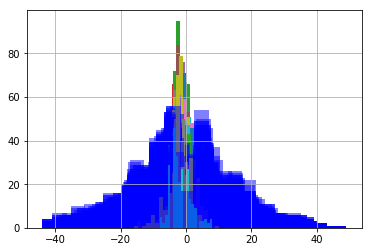

In [11]:
%%time
numSimulations = 400
pred_2019 = pd.DataFrame(columns = ['GameNum', 'Predicted_Spread', 'Game_Spread', 'Predicted_OU', 'Game_OU'])
next_week_pred=pd.DataFrame(columns = ['GameNum','Predicted_Spread'])

for i in range(0,numSimulations):
    print "\n\nNow Starting Simulation Number: " + str(i+1) + "\n\n"
    future_pred, past_pred = simulatePrediction(int(random()*1000000))
    next_week_pred = next_week_pred.append(future_pred)
    pred_2019 = pred_2019.append(past_pred)
    


In [14]:
lastpast = pd.read_csv('past_game_predictions_12_15.csv')
lastfuture = pd.read_csv('future_game_predictions_12_15.csv')

lastpast = lastpast.append(pred_2019)
lastfuture = lastfuture.append(next_week_pred)

In [15]:
pred_2019.to_csv('past_game_predictions_12_15_300.csv')
next_week_pred.to_csv('future_game_predictions_12_15_300.csv')

lastpast.to_csv('past_game_predictions_12_15_merge.csv')
lastfuture.to_csv('future_game_predictions_12_15_merge.csv')